In [39]:
# Import numpy and matplotlib
from collections import namedtuple
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import simps
from glob import glob
import os
from tqdm.notebook import tqdm, trange
import pandas as pd
from scipy.interpolate import UnivariateSpline
import netCDF4 as nc
# Modify the style of the plots
plt.style.use('seaborn-whitegrid')

# Diffusivity profile

Timesteplimit, profile B:  1115.7016960273738
0.023686632124930673


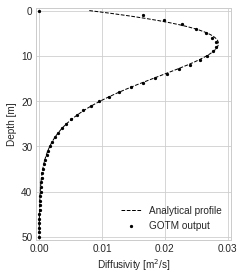

In [40]:
def f(z, a, b, c,z0):
    return a*(z+z0)*np.exp(-b*(z+z0)**c)

def g(z, a, b, c, z0):
    return a*(z+z0)*np.exp(-(b*(z+z0))**c)

def d2dz2(f, z, dz = 1e-5):
    return (f(z+dz, 0)-2*f(z, 0)+f(z-dz, 0))/dz**2


zc = np.linspace(0, 100, 1000)

fig = plt.figure(figsize = (3.5, 4))

with nc.Dataset('../gotm/entrainment.nc') as d:
    # Strip away superfluous size-1 dimensions
    avh = np.array(d.variables['avh'][:,:,0,0])
    z = np.array(np.abs(d.variables['z'][0,:,0,0]))
    z = z - z[-1]
    
    outputtime = 72*3600
    it = np.argmin(np.abs(d.variables['time'][:] - outputtime))
    plt.scatter(avh[it,1::2], z[1::2], marker = '.', s = 20, lw  = 1, c = 'k', label = 'GOTM output')
#    plt.plot(f(zc, a, b, c), zc, c = 'k', lw = 2, alpha = 0.5, label = 'Analytical, fitted')

    a, b, c, z0 = [0.00636, 0.0237, 1.54, 1.3]
    K_B = lambda z, t: a*(z+z0)*np.exp(-b*(z+z0)**c)

    plt.plot(f(zc, a, b, c, z0), zc, '--', c = 'k', lw = 1, alpha = 1, label = 'Analytical profile')
    
    plt.gca().set_facecolor('white')
    
    plt.ylim(50.6, -0.6)
    plt.xlim(-0.0005,0.0305)
#    plt.xlim(1e-5, 1e-1)
#    plt.xscale('log')
    plt.ylabel('Depth [m]')
    plt.xlabel('Diffusivity [m$^2$/s]')
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.savefig('diffusivity_profile.pdf')
            
print('Timesteplimit, profile B: ', np.min(np.abs(1/d2dz2(K_B, zc))))
print(0.088**c)

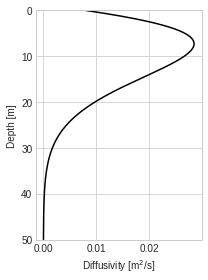

In [15]:
beta = 0.00636
gamma = 0.088
delta = 1.54
z0 = 1.3

K = lambda z: beta*(z + z0)*np.exp(-(gamma*(z + z0))**delta)

zc = np.linspace(0, 50, 1000)

fig = plt.figure(figsize = (3, 4))
plt.plot(K(zc), zc, c = 'k')
plt.ylim(50, 0)
plt.xlabel('Diffusivity [m$^2$/s]')
plt.ylabel('Depth [m]')
plt.tight_layout()
plt.savefig('diffusivity_profile.pdf')

# Parse all the particle data and pre-generate data for plotting

In [188]:
datafolder = '/media/torn/SSD/EulerLagrange/'

# Create a dataframe to hold all the results

df = pd.DataFrame(columns = ['Case', 'Profile', 'Np', 'dt', 'run_id', 'timestep', 'moment'])

for case in [1,2,3,4]:
    for profile in ['A', 'B']:
        datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles*_Z_*.npy'))
        
        # What we actually want to plot is the first moment of the distribution,
        # i.e., the average position of submerged particles
        
        dts = set([])
        Nps = set([])
            
        for datafile in tqdm(datafiles):
            # Parse simulation parameters
            Np     = int(   datafile.split('_')[-4].split('=')[-1])
            dt     = float( datafile.split('_')[-3].split('=')[-1])
            run_id = int(   datafile.split('_')[-1].split('.')[-2])
            # Keep track of parameters spanned by the simulations
            dts.add(dt)
            Nps.add(Np)
            # Load the particle positions
            Z = np.load(datafile)
            # Calculate moments for each timestep
            moments = np.array([np.mean(z_[z_ >= 0]) if len(z_) > 0 else -999 for z_ in Z])
            timesteps = np.arange(len(moments), dtype = np.int64)
            df = df.append(
                pd.DataFrame({
                        'Case' : case,
                        'Profile' : profile,
                        'Np' : Np,
                        'dt' : dt,
                        'run_id' : run_id,
                        'timestep' : timesteps,
                        'moment' : moments,
                }))
        
        print(case, profile)
        print('dts = ', sorted(dts))
        print('Nps = ', sorted(Nps))
            

  0%|          | 0/1400 [00:00<?, ?it/s]

/home/torn/miniforge3/envs/default/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/torn/miniforge3/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 A
dts =  [2.0, 10.0, 30.0, 60.0, 180.0, 360.0, 600.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]


  0%|          | 0/1400 [00:00<?, ?it/s]

1 B
dts =  [2.0, 10.0, 30.0, 60.0, 180.0, 360.0, 600.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]


  0%|          | 0/1400 [00:00<?, ?it/s]

2 A
dts =  [2.0, 5.0, 10.0, 30.0, 60.0, 180.0, 360.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]


  0%|          | 0/1400 [00:00<?, ?it/s]

2 B
dts =  [2.0, 5.0, 10.0, 30.0, 60.0, 180.0, 360.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]


  0%|          | 0/1600 [00:00<?, ?it/s]

3 A
dts =  [0.25, 2.0, 5.0, 10.0, 30.0, 60.0, 180.0, 360.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 3000000]


  0%|          | 0/1600 [00:00<?, ?it/s]

3 B
dts =  [0.25, 2.0, 5.0, 10.0, 30.0, 60.0, 180.0, 360.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 3000000]


  0%|          | 0/1265 [00:00<?, ?it/s]

4 A
dts =  [1.0, 2.0, 5.0, 10.0, 20.0, 60.0, 120.0, 300.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]


  0%|          | 0/1263 [00:00<?, ?it/s]

4 B
dts =  [1.0, 2.0, 5.0, 10.0, 20.0, 60.0, 120.0, 300.0]
Nps =  [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]


In [189]:
df.to_pickle('moments.pkl')

In [41]:
df = pd.read_pickle('moments.pkl')

In [2]:
def plot_particle_convergence(case, profile, dt, it, data, ax = None, dt_save = 1800):
    if ax is None:
        fig, ax = plt.subplots(ncols = 1, figsize = (9, 5))
    subset = data[((data['Case'] == case) & (data['Profile'] == profile))]
    Nps = np.array(sorted(set(subset['Np'])))
    moment_ref = np.mean(subset[((subset['dt'] == dt) & (subset['Np'] == Nps[-1]) & (subset['timestep'] == it))]['moment'])
    std_devs = np.array([
        np.std(subset[((subset['Np'] == Np) & (subset['dt'] == dt) & (subset['timestep'] == it))]['moment'] - moment_ref) for Np in Nps
    ])
    ax.plot(Nps, std_devs, label = f'{it*dt_save/3600} hours')
    # Plot trendline
    #ax.plot(Nps, std_devs[0]*np.sqrt(Nps[0]/Nps[:]))
    return Nps, ax

def plot_class_convergence(case, profile, dt, NJ, it, ax = None, dt_save = 1800, datafolder = '/media/torn/SSD/EulerLagrange/'):
    # Max depth (constant for all cases)
    Zmax = 50
    # List of data files
    datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses=*_NJ={NJ}_dt={dt}.npy'))
    if len(datafiles) == 0:
        datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses=*_NJ={NJ}_dt={int(dt)}.npy'))
    NKs = np.array(sorted(
            [int(datafile.split('_')[-3].split('=')[-1]) for datafile in datafiles]
        ))
    moments = np.zeros(NKs.shape)
    for i, NK in enumerate(NKs):
        try:
            C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={dt}.npy')).sum(axis = 1)
        except:
            C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={int(dt)}.npy')).sum(axis = 1)
        zf, dz = np.linspace(0, Zmax, C.shape[-1]+1, retstep=True)
        zc = zf[:-1] + dz/2
        moments[i] = dz*np.sum(zc*C[it,:])
        
    # Use the last moment (with the highest NK) as a reference
    errors = np.abs(moments[:-1] - moments[-1])
    ax.plot(NKs[:-1], errors, label = f'{it*dt_save/3600} hours')
    # Plot trendline
    #ax.plot(NKs[:-1], errors[0]*NKs[0]**2/NKs[:-1]**2, '--', c = 'k')
    return NKs, ax

def plot_concentration_comparison(case, profile, dt_L, Np, dt_E, NK, NJ, it, ax = None, dt_save = 1800, datafolder = '/media/torn/SSD/EulerLagrange/'):
    # Max depth (constant for all cases)
    Zmax = 50
    
    # Load particle data
    run_id = 0
    # Number of bins to use in particle histogram
    Nbins = 100
    try:
        Z = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt_L}_Z_{run_id:04}.npy'))
    except:
        Z = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={int(dt_L)}_Z_{run_id:04}.npy'))
    # Histogram bins
    bins, delta = np.linspace(0, Zmax, Nbins+1, retstep = True)
    mids = bins[:-1] + delta/2
    h, _ = np.histogram(Z[it,:][Z[it,:] >= 0], bins = bins)
    l, = ax.plot(h/(delta*Np), mids, label = f'{it*dt_save/3600} hours')
    
    # Load grid data
    try:
        C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={dt_E}.npy')).sum(axis = 1)
    except:
        C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={int(dt_E)}.npy')).sum(axis = 1)
    zf, dz = np.linspace(0, Zmax, C.shape[-1]+1, retstep=True)
    zc = zf[:-1] + dz/2
#    ax.plot(C[it,:], zc, '--', c = l.get_color())
    ax.plot(C[it,:], zc, '--', c = 'k', lw = 1)
    return ax

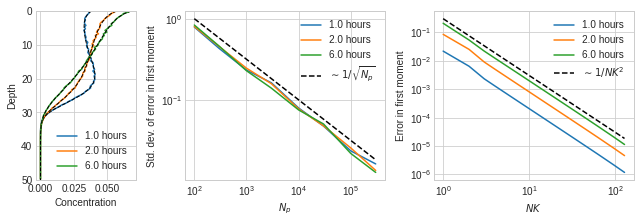

In [159]:
fig = plt.figure(figsize=(9,3.2))
ax = []
ax.append(fig.add_subplot(1, 13, (1,3)))
ax.append(fig.add_subplot(1, 13, (4,8)))
ax.append(fig.add_subplot(1, 13, (9,13)))

case = 1
profile = 'B'
dt_L = 10.0
dt_E = 60
NJ = 4000

# Use these parameters for concentration comparison
Np = 300000
NK = 128

for it in [2, 4, 12]:
    _ = plot_concentration_comparison(case, profile, dt_L, Np, dt_E, NK, NJ, it, ax = ax[0])
    Nps, _ = plot_particle_convergence(case, profile, dt_L, it, df, ax = ax[1])
    NKs, _ = plot_class_convergence(case, profile, dt_E, NJ, it, ax = ax[2])

    
# Add labels to concentration plots
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth')
# Flip axis on concentration plots
ax[0].set_ylim(50, 0)

# Add labels to particle convergence
ax[1].set_xlabel('$N_p$')
ax[1].set_ylabel('Std. dev. of error in first moment')

# Add labels to class convergence
ax[2].set_xlabel('$NK$')
ax[2].set_ylabel('Error in first moment')

# Plot trendlines
ax[1].plot(Nps, 10/np.sqrt(Nps), '--', c = 'k', label = '$\sim 1/\sqrt{N_p}$')
ax[2].plot(NKs[:-1], 0.3/NKs[:-1]**2, '--', c = 'k', label = '$\sim 1/NK^2$')

# Logscale
for i in [1,2]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

# Legend
for i in [0,1,2]:
    ax[i].legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'summary_plot_{case}_{profile}.png', dpi=240)

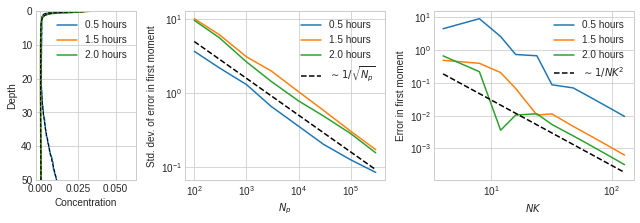

In [172]:
fig = plt.figure(figsize=(9,3.2))
ax = []
ax.append(fig.add_subplot(1, 13, (1,3)))
ax.append(fig.add_subplot(1, 13, (4,8)))
ax.append(fig.add_subplot(1, 13, (9,13)))

case = 2
profile = 'B'
dt_L = 2.0
dt_E = 1.0
NJ = 4000

# Use these parameters for concentration comparison
Np = 300000
NK = 128

for it in [1, 3, 4]:
    _ = plot_concentration_comparison(case, profile, dt_L, Np, dt_E, NK, NJ, it, ax = ax[0])
    Nps, _ = plot_particle_convergence(case, profile, dt_L, it, df, ax = ax[1])
    NKs, _ = plot_class_convergence(case, profile, dt_E, NJ, it, ax = ax[2])

    
# Add labels to concentration plots
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth')
# Flip axis on concentration plots
ax[0].set_ylim(50, 0)

# Add labels to particle convergence
ax[1].set_xlabel('$N_p$')
ax[1].set_ylabel('Std. dev. of error in first moment')

# Add labels to class convergence
ax[2].set_xlabel('$NK$')
ax[2].set_ylabel('Error in first moment')

# Plot trendlines
ax[1].plot(Nps, 50/np.sqrt(Nps), '--', c = 'k', label = '$\sim 1/\sqrt{N_p}$')
ax[2].plot(NKs[:-1], 3/NKs[:-1]**2, '--', c = 'k', label = '$\sim 1/NK^2$')

# Logscale
for i in [1,2]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

# Legend
for i in [0,1,2]:
    ax[i].legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'summary_plot_{case}_{profile}.png', dpi=240)

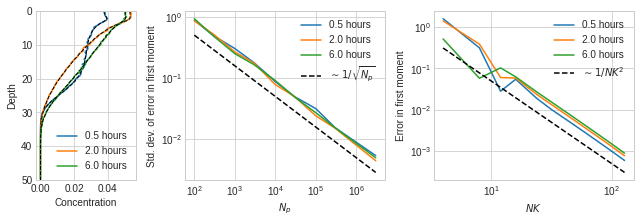

In [215]:
fig = plt.figure(figsize=(9,3.2))
ax = []
ax.append(fig.add_subplot(1, 13, (1,3)))
ax.append(fig.add_subplot(1, 13, (4,8)))
ax.append(fig.add_subplot(1, 13, (9,13)))

case = 3
profile = 'B'
dt_L = 2.0
dt_E = 1.0
NJ = 4000

# Use these parameters for concentration comparison
Np = 300000
NK = 128

for it in [1, 4, 12]:
    _ = plot_concentration_comparison(case, profile, dt_L, Np, dt_E, NK, NJ, it, ax = ax[0])
    Nps, _ = plot_particle_convergence(case, profile, dt_L, it, df, ax = ax[1])
    NKs, _ = plot_class_convergence(case, profile, dt_E, NJ, it, ax = ax[2])

    
# Add labels to concentration plots
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth')
# Flip axis on concentration plots
ax[0].set_ylim(50, 0)

# Add labels to particle convergence
ax[1].set_xlabel('$N_p$')
ax[1].set_ylabel('Std. dev. of error in first moment')

# Add labels to class convergence
ax[2].set_xlabel('$NK$')
ax[2].set_ylabel('Error in first moment')

# Plot trendlines
ax[1].plot(Nps, 5/np.sqrt(Nps), '--', c = 'k', label = '$\sim 1/\sqrt{N_p}$')
ax[2].plot(NKs[:-1], 5/NKs[:-1]**2, '--', c = 'k', label = '$\sim 1/NK^2$')

# Logscale
for i in [1,2]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

# Legend
for i in [0,1,2]:
    ax[i].legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'summary_plot_{case}_{profile}.png', dpi=240)

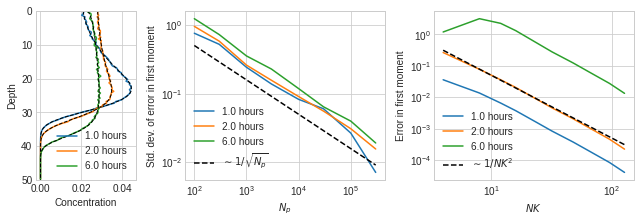

In [216]:
fig = plt.figure(figsize=(9,3.2))
ax = []
ax.append(fig.add_subplot(1, 13, (1,3)))
ax.append(fig.add_subplot(1, 13, (4,8)))
ax.append(fig.add_subplot(1, 13, (9,13)))

case = 4
profile = 'B'
dt_L = 5.0
dt_E = 10.0
NJ = 4000

# Use these parameters for concentration comparison
Np = 300000
NK = 128

for it in [2, 4, 12]:
    _ = plot_concentration_comparison(case, profile, dt_L, Np, dt_E, NK, NJ, it, ax = ax[0])
    Nps, _ = plot_particle_convergence(case, profile, dt_L, it, df, ax = ax[1])
    NKs, _ = plot_class_convergence(case, profile, dt_E, NJ, it, ax = ax[2])

    
# Add labels to concentration plots
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth')
# Flip axis on concentration plots
ax[0].set_ylim(50, 0)

# Add labels to particle convergence
ax[1].set_xlabel('$N_p$')
ax[1].set_ylabel('Std. dev. of error in first moment')

# Add labels to class convergence
ax[2].set_xlabel('$NK$')
ax[2].set_ylabel('Error in first moment')

# Plot trendlines
ax[1].plot(Nps, 5/np.sqrt(Nps), '--', c = 'k', label = '$\sim 1/\sqrt{N_p}$')
ax[2].plot(NKs[:-1], 5/NKs[:-1]**2, '--', c = 'k', label = '$\sim 1/NK^2$')

# Logscale
for i in [1,2]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

# Legend
for i in [0,1,2]:
    ax[i].legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'summary_plot_{case}_{profile}.png', dpi=240)

# Convergence with time and space

In [37]:
def plot_time_convergence_lagrange(case, profile, Np, it, data, ax = None, dt_save = 1800, return_colour = False):
    if ax is None:
        fig, ax = plt.subplots(ncols = 1, figsize = (9, 5))
    subset = data[((data['Case'] == case) & (data['Profile'] == profile))]
    Nps = np.array(sorted(set(subset['Np'])))
    dts = np.array(sorted(set(subset['dt'])))
    moment_ref = np.mean(subset[((subset['dt'] == dts[0]) & (subset['Np'] == Np) & (subset['timestep'] == it))]['moment'])
    means = np.array([
        np.mean(np.abs(
            subset[((subset['Np'] == Np) & (subset['dt'] == dt) & (subset['timestep'] == it))]['moment'] - moment_ref
        )) for dt in dts
    ])
    l, = ax.plot(dts, means, label = f'{it*dt_save/3600} hours')
    # Plot trendline
    #ax.plot(Nps, std_devs[0]*np.sqrt(Nps[0]/Nps[:]))
    if return_colour:
        return dts, ax, l.get_color()
    else:
        return dts, ax

def plot_time_convergence_euler(case, profile, NK, NJ, it, ax = None, dt_save = 1800, datafolder = '/media/torn/SSD/EulerLagrange/'):
    # Max depth (constant for all cases)
    Zmax = 50
    # List of data files
    datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt=*.npy'))
    dts = np.array(sorted(
            [float(datafile.split('_')[-1].split('=')[-1].replace('.npy', '')) for datafile in datafiles]
        ))
    moments = np.zeros(dts.shape)
    for i, dt in enumerate(dts):
        try:
            C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={dt}.npy')).sum(axis = 1)
        except:
            C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={int(dt)}.npy')).sum(axis = 1)
        zf, dz = np.linspace(0, Zmax, C.shape[-1]+1, retstep=True)
        zc = zf[:-1] + dz/2
        moments[i] = dz*np.sum(zc*C[it,:])
        
    # Use the last moment (with the highest NK) as a reference
    errors = np.abs(moments[1:] - moments[0])
    ax.plot(dts[1:], errors, label = f'{it*dt_save/3600} hours')
    # Plot trendline
    #ax.plot(NKs[:-1], errors[0]*NKs[0]**2/NKs[:-1]**2, '--', c = 'k')
    return dts, ax

def plot_space_convergence_euler(case, profile, dt, NK, it, ax = None, dt_save = 1800, datafolder = '/media/torn/SSD/EulerLagrange/'):
    # Max depth (constant for all cases)
    Zmax = 50
    # List of data files
    datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ=*_dt={dt}.npy'))
    if len(datafiles) == 0:
        datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ=*_dt={int(dt)}.npy'))
    NJs = np.array(sorted(
            [int(datafile.split('_')[-2].split('=')[-1]) for datafile in datafiles]
        ))
    moments = np.zeros(NJs.shape)
    for i, NJ in enumerate(NJs):
        try:
            C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={dt}.npy')).sum(axis = 1)
        except:
            C = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_block_Nclasses={NK}_NJ={NJ}_dt={int(dt)}.npy')).sum(axis = 1)
        zf, dz = np.linspace(0, Zmax, C.shape[-1]+1, retstep=True)
        zc = zf[:-1] + dz/2
        moments[i] = dz*np.sum(zc*C[it,:])
        
    # Use the last moment (with the highest NK) as a reference
    errors = np.abs(moments[:-1] - moments[-1])
    dz_list = Zmax / NJs
    ax.plot(dz_list[:-1], errors, label = f'{it*dt_save/3600} hours')
    # Plot trendline
    #ax.plot(NKs[:-1], errors[0]*NKs[0]**2/NKs[:-1]**2, '--', c = 'k')
    return dz_list, ax

def get_variance(case, profile, dt, Np, it, datafolder = '/media/torn/SSD/EulerLagrange/'):
    datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt}_Z_*.npy'))
    if len(datafiles) == 0:
        datafiles = glob(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={int(dt)}_Z_*.npy'))
    variance = 0
    for datafile in datafiles:
        Z = np.load(datafile)
        variance += np.var(Z[it,:][(Z[it,:] >= 0) & (Z[it,:] <= 50)])
    return variance/len(datafiles)

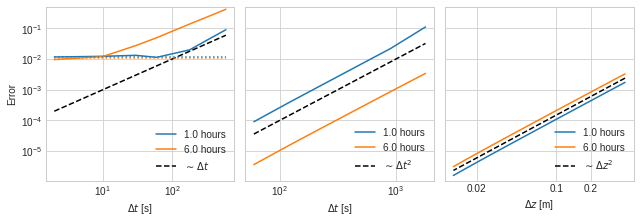

In [42]:
fig, ax = plt.subplots(ncols = 3, figsize = (9,3.2), sharey = True)

case = 1
profile = 'B'

dts_L, _, colour_1 = plot_time_convergence_lagrange(case, profile, 300000, 2, df, ax = ax[0], return_colour = True)
dts_L, _, colour_2 = plot_time_convergence_lagrange(case, profile, 300000, 12, df, ax = ax[0], return_colour = True)
ax[0].plot(dts_L, 1e-4*dts_L, '--', c = 'k', label = '$\sim \Delta t$')

# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 300000, 2)
sampling_error = np.sqrt(2/np.pi)*np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_1)
# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 300000, 12)
sampling_error = np.sqrt(2/np.pi)*np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_2)

dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 2, ax = ax[1])
dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 12, ax = ax[1])
ax[1].plot(dts_E[1:], 1e-8*dts_E[1:]**2, '--', c = 'k', label = '$\sim \Delta t^2$')

dzs, _ = plot_space_convergence_euler(case, profile, 60, 128, 2, ax = ax[2])
dzs, _ = plot_space_convergence_euler(case, profile, 60, 128, 12, ax = ax[2])
ax[2].plot(dzs[:-1], 1.5e-2*dzs[:-1]**2, '--', c = 'k', label = '$\sim \Delta z^2$')

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(loc = 'lower right')

ax[0].set_ylabel('Error')
ax[0].set_xlabel('$\Delta t$ [s]')
ax[1].set_xlabel('$\Delta t$ [s]')
ax[2].set_xlabel('$\Delta z$ [m]')
ax[2].set_xticks([0.02, 0.1, 0.2])
ax[2].set_xticklabels([0.02, 0.1, 0.2])
ax[0].set_ylim(1.1e-6, 5e-1)
plt.tight_layout()
plt.savefig(f'extra_converegence_plot_{case}_{profile}.png', dpi=240)

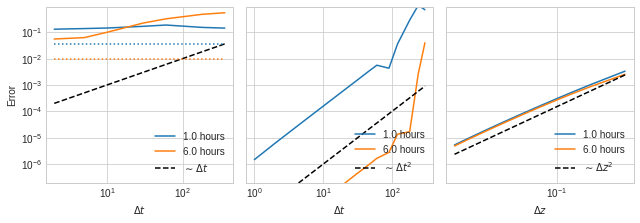

In [37]:
fig, ax = plt.subplots(ncols = 3, figsize = (9,3.2), sharey = True)

case = 2
profile = 'B'

dts_L, _, colour_1 = plot_time_convergence_lagrange(case, profile, 300000, 2, df, ax = ax[0], return_colour = True)
dts_L, _, colour_2 = plot_time_convergence_lagrange(case, profile, 300000, 12, df, ax = ax[0], return_colour = True)
ax[0].plot(dts_L, 1e-4*dts_L, '--', c = 'k', label = '$\sim \Delta t$')

# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 300000, 2)
sampling_error = np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_1)
# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 300000, 12)
sampling_error = np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_2)

dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 2, ax = ax[1])
dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 12, ax = ax[1])
ax[1].plot(dts_E[1:], 1e-8*dts_E[1:]**2, '--', c = 'k', label = '$\sim \Delta t^2$')

dzs, _ = plot_space_convergence_euler(case, profile, 1.0, 128, 2, ax = ax[2])
dzs, _ = plot_space_convergence_euler(case, profile, 1.0, 128, 12, ax = ax[2])
ax[2].plot(dzs[:-1], 1.5e-2*dzs[:-1]**2, '--', c = 'k', label = '$\sim \Delta z^2$')

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(loc = 'lower right')

ax[0].set_ylabel('Error')
ax[0].set_xlabel('$\Delta t$')
ax[1].set_xlabel('$\Delta t$')
ax[2].set_xlabel('$\Delta z$')
ax[0].set_ylim(2e-7, 9e-1)
plt.tight_layout()
plt.savefig(f'extra_converegence_plot_{case}_{profile}.png', dpi=240)

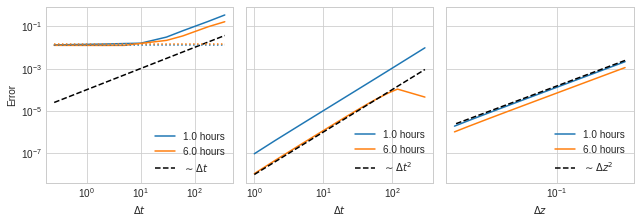

In [34]:
fig, ax = plt.subplots(ncols = 3, figsize = (9,3.2), sharey = True)

case = 3
profile = 'B'


dts_L, _, colour_1 = plot_time_convergence_lagrange(case, profile, 300000, 2, df, ax = ax[0], return_colour = True)
dts_L, _, colour_2 = plot_time_convergence_lagrange(case, profile, 300000, 12, df, ax = ax[0], return_colour = True)
ax[0].plot(dts_L, 1e-4*dts_L, '--', c = 'k', label = '$\sim \Delta t$')

# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[0], 300000, 2)
sampling_error = np.sqrt(2/np.pi)*np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_1)
# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[0], 300000, 12)
sampling_error = np.sqrt(2/np.pi)*np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_2)

dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 2, ax = ax[1])
dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 12, ax = ax[1])
ax[1].plot(dts_E[1:], 1e-8*dts_E[1:]**2, '--', c = 'k', label = '$\sim \Delta t^2$')

dzs, _ = plot_space_convergence_euler(case, profile, 1.0, 128, 2, ax = ax[2])
dzs, _ = plot_space_convergence_euler(case, profile, 1.0, 128, 12, ax = ax[2])
ax[2].plot(dzs[:-1], 1.5e-2*dzs[:-1]**2, '--', c = 'k', label = '$\sim \Delta z^2$')

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(loc = 'lower right')

ax[0].set_ylabel('Error')
ax[0].set_xlabel('$\Delta t$')
ax[1].set_xlabel('$\Delta t$')
ax[2].set_xlabel('$\Delta z$')
plt.tight_layout()
plt.savefig(f'extra_converegence_plot_{case}_{profile}.png', dpi=240)

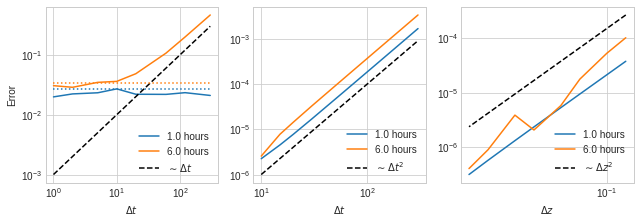

In [31]:
fig, ax = plt.subplots(ncols = 3, figsize = (9,3.2))

case = 4
profile = 'B'

dts_L, _, colour_1 = plot_time_convergence_lagrange(case, profile, 100000, 2, df, ax = ax[0], return_colour = True)
dts_L, _, colour_2 = plot_time_convergence_lagrange(case, profile, 100000, 12, df, ax = ax[0], return_colour = True)
ax[0].plot(dts_L, 1e-3*dts_L, '--', c = 'k', label = '$\sim \Delta t$')

# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 100000, 2)
sampling_error = np.sqrt(2/np.pi)*np.sqrt(var/100000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_1)
# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 100000, 12)
sampling_error = np.sqrt(2/np.pi)*np.sqrt(var/100000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_2)

dts_E, _ = plot_time_convergence_euler(case, profile, 64, 4000, 2, ax = ax[1])
dts_E, _ = plot_time_convergence_euler(case, profile, 64, 4000, 12, ax = ax[1])
ax[1].plot(dts_E[1:], 1e-8*dts_E[1:]**2, '--', c = 'k', label = '$\sim \Delta t^2$')

dzs, _ = plot_space_convergence_euler(case, profile, 10.0, 64, 2, ax = ax[2])
dzs, _ = plot_space_convergence_euler(case, profile, 10.0, 64, 12, ax = ax[2])
ax[2].plot(dzs[:-1], 1.5e-2*dzs[:-1]**2, '--', c = 'k', label = '$\sim \Delta z^2$')

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(loc = 'lower right')

ax[0].set_ylabel('Error')
ax[0].set_xlabel('$\Delta t$')
ax[1].set_xlabel('$\Delta t$')
ax[2].set_xlabel('$\Delta z$')
plt.tight_layout()
plt.savefig(f'extra_converegence_plot_{case}_{profile}.png', dpi=240)

In [41]:
df[( (df['Case'] == 4) & (df['Profile'] == 'B') & (df['run_id'] == 0) & (df['timestep'] == 1))]

,Case,Profile,Np,dt,run_id,timestep,moment
1,4,B,100000,60.0,0,1,18.101017
1,4,B,30000,5.0,0,1,18.058969
1,4,B,1000,5.0,0,1,17.888116
1,4,B,3000,5.0,0,1,17.989312
1,4,B,300000,5.0,0,1,18.105742
1,4,B,100000,300.0,0,1,18.074929
1,4,B,100000,2.0,0,1,18.076219
1,4,B,100000,10.0,0,1,18.139836
1,4,B,300,5.0,0,1,17.985901
1,4,B,100,5.0,0,1,17.808989


In [210]:
df[( (df['Case'] == 4) & (df['Profile'] == 'B') )]

,Case,Profile,Np,dt,run_id,timestep,moment
0,4,B,100000,300.0,10,0,20.009187
1,4,B,100000,300.0,10,1,18.096225
2,4,B,100000,300.0,10,2,17.209818
3,4,B,100000,300.0,10,3,16.867367
4,4,B,100000,300.0,10,4,16.753537
...,...,...,...,...,...,...,...
44,4,B,1000,5.0,72,44,29.460180
45,4,B,1000,5.0,72,45,28.254178
46,4,B,1000,5.0,72,46,28.310566
47,4,B,1000,5.0,72,47,28.138552


(481, 4000)
0.002169488214799398


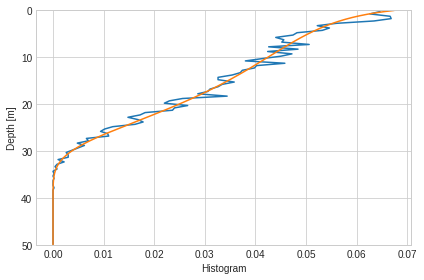

In [23]:
#### Total integration time
Tmax = 12*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters
dt_save = 1800
dt    = 10    # Timestep
Nrun  = 0
Np   = 10000

# Hours after which to plot the solutions
hours = [1, 2, 4]

# Case
case = 1
# profile
profile = 'B'
# timestep
it = 10


datafile_lagrangian = f'/media/torn/SSD/EulerLagrange/Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt}_Z_{Nrun:04}.npy'
Z = np.load(datafile_lagrangian)
#print(Z.shape)


datafile_eulerian = f'/media/torn/SSD/EulerLagrange/Case1_K_B_block_Nclasses=128_NJ=4000_dt=15.npy'
C = np.load(datafile_eulerian).sum(axis = 1)
print(C.shape)


bins, dzL = np.linspace(0, 50, 101, retstep = True)
mids = bins[1:] - dzL/2
counts, _ = np.histogram(Z[it,:], bins = bins, density = True)
plt.plot(counts, mids)

zf, dzE = np.linspace(0, 50, C.shape[-1]+1, retstep = True)
zc = zf[1:] - dzE/2
plt.plot(C[it,:], zc)


plt.ylim(50, 0)
plt.ylabel('Depth [m]')
plt.xlabel('Histogram')
plt.tight_layout()


# Interpolator for evaluating Eulerian at arbitrary points
C_interp = UnivariateSpline(zc, C[it,:], k = 1, s = 0)


RMSE = np.sqrt(np.mean( (counts - C_interp(mids))**2 ) )

print(RMSE)

In [18]:
dt = 10
# Case
case = 1
# profile
profile = 'B'
# timestep to plot
it = 10
# Number of runs
Nruns = 100


datafile_eulerian = f'/media/torn/SSD/EulerLagrange/Case1_K_B_block_Nclasses=128_NJ=4000_dt=15.npy'
C = np.load(datafile_eulerian).sum(axis = 1)
#print(C.shape)
# Eulerian grid parameters
zf, dzE = np.linspace(0, 50, C.shape[-1]+1, retstep = True)
zc = zf[1:] - dzE/2
# Interpolator for evaluating Eulerian at arbitrary points
C_interp = UnivariateSpline(zc, C[it,:], k = 3, s = 0)


Nbins = np.array([11, 31, 101, 301, 1001])


Nps = np.array([100, 1000, 10000, 100000])
RMSEs = np.zeros((Nruns, Nps.size, Nbins.size))

for ib, Nbin in tqdm(enumerate(Nbins), total = len(Nbins)):
    # Lagrangian histogram parameters
    bins, dzL = np.linspace(0, 50, Nbin, retstep = True)
    mids = bins[1:] - dzL/2

    for i, Np in enumerate(Nps):

        for n in range(Nruns):

            datafile_lagrangian = f'/media/torn/SSD/EulerLagrange/Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt}_Z_{n:04}.npy'
            Z = np.load(datafile_lagrangian)

            counts, _ = np.histogram(Z[it,:], bins = bins, density = True)

            RMSEs[n, i, ib] = np.sqrt(np.mean( (counts - C_interp(mids))**2 ) )

  0%|          | 0/5 [00:00<?, ?it/s]

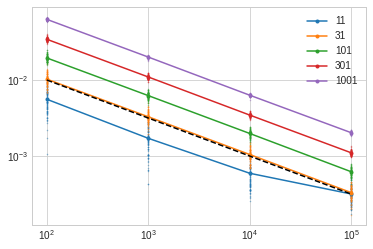

In [19]:
for ib, Nbin in enumerate(Nbins):

    l,  = plt.plot(Nps, np.mean(RMSEs[:,:,ib], axis = 0), marker = '.', label = Nbin)
    for n in range(Nruns):
        plt.scatter(Nps, RMSEs[n, :, ib], c = l.get_color(), marker = '.', s = 1, alpha = 0.5)
                   
                   
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.plot(Nps, 0.1/np.sqrt(Nps), '--', c = 'k')

In [26]:
dt = 10
# Case
case = 1
# profile
profile = 'B'
# timestep to plot
it = 10
# Number of runs
Nruns = 100


datafile_eulerian = f'/media/torn/SSD/EulerLagrange/Case1_K_B_block_Nclasses=128_NJ=4000_dt=15.npy'
C = np.load(datafile_eulerian).sum(axis = 1)
#print(C.shape)
# Eulerian grid parameters
zf, dzE = np.linspace(0, 50, C.shape[-1]+1, retstep = True)
zc = zf[1:] - dzE/2
# Interpolator for evaluating Eulerian at arbitrary points
C_interp = UnivariateSpline(zc, C[it,:], k = 3, s = 0)


Nbins = np.array([11, 31, 101, 301, 1001])


Nps = np.array([100, 1000, 10000, 100000])
RMSEs = np.zeros((Nruns, Nps.size, Nbins.size))

for ib, Nbin in tqdm(enumerate(Nbins), total = len(Nbins)):
    # Lagrangian histogram parameters
    bins, dzL = np.linspace(0, 50, Nbin, retstep = True)
    mids = bins[1:] - dzL/2

    for i, Np in enumerate(Nps):

        for n in range(Nruns):

            datafile_lagrangian = f'/media/torn/SSD/EulerLagrange/Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt}_Z_{n:04}.npy'
            Z = np.load(datafile_lagrangian)

            counts, _ = np.histogram(Z[it,:], bins = bins, density = True)

            reference = np.array([C_interp.integral(bins[j], bins[j+1]) for j in range(len(bins)-1)])
                
            RMSEs[n, i, ib] = np.sqrt(np.mean( (counts - reference/dzL)**2 ) )

  0%|          | 0/5 [00:00<?, ?it/s]

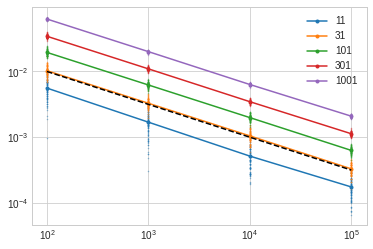

In [27]:
for ib, Nbin in enumerate(Nbins):

    l,  = plt.plot(Nps, np.mean(RMSEs[:,:,ib], axis = 0), marker = '.', label = Nbin)
    for n in range(Nruns):
        plt.scatter(Nps, RMSEs[n, :, ib], c = l.get_color(), marker = '.', s = 1, alpha = 0.5)
                   
                   
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.plot(Nps, 0.1/np.sqrt(Nps), '--', c = 'k')

In [25]:
C_interp.integral(0, 25) + C_interp.integral(25, 50)

0.9995783448308673

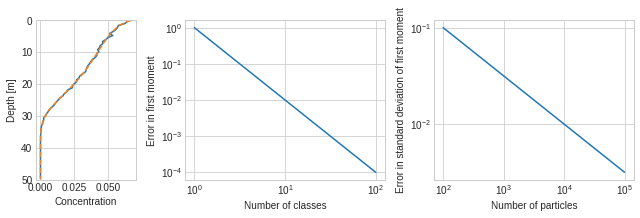

In [59]:
fig = plt.figure(figsize=(9,3))
ax = []
ax.append(fig.add_subplot(1, 13, (1,3)))
ax.append(fig.add_subplot(1, 13, (4,8)))
ax.append(fig.add_subplot(1, 13, (9,13)))


case = 1
profile = 'B'


datafile_eulerian = f'/media/torn/SSD/EulerLagrange/Case{case}_K_{profile}_block_Nclasses=128_NJ=4000_dt=15.npy'
C = np.load(datafile_eulerian).sum(axis = 1)
#print(C.shape)
# Eulerian grid parameters
zf, dzE = np.linspace(0, 50, C.shape[-1]+1, retstep = True)
zc = zf[1:] - dzE/2


# Lagrangian histogram parameters
Nbins = 80
bins, dzL = np.linspace(0, 50, Nbins, retstep = True)
mids = bins[1:] - dzL/2


Np = 100000
dt = 10
it = 10

datafile_lagrangian = f'/media/torn/SSD/EulerLagrange/Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt}_Z_{n:04}.npy'
Z = np.load(datafile_lagrangian)

counts, _ = np.histogram(Z[it,:], bins = bins, density = True)


ax[0].plot(counts, mids, label='Lagrangian')
ax[0].plot(C[it,:], zc, '--', label='Eulerian')

ax[0].set_ylim(50, 0)
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Concentration')


NK = np.logspace(0, 2, 100)
ax[1].plot(NK, 1/NK**2)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Number of classes')
ax[1].set_ylabel('Error in first moment')

Np = np.logspace(2, 5, 100)
ax[2].plot(Np, 1/np.sqrt(Np))
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_ylabel('Standard deviation in error of first moment')
ax[2].set_xlabel('Number of particles')


plt.tight_layout()
#plt.subplots_adjust(wspace=100)

In [126]:
i = 32
print(f'{i:04}')

0032


In [39]:
1200 / 8, 1500 / 10

(150.0, 150.0)

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize = (9,3.2), sharey = True)

case = 2
profile = 'B'

dts_L, _, colour_1 = plot_time_convergence_lagrange(case, profile, 300000, 2, df, ax = ax[0], return_colour = True)
dts_L, _, colour_2 = plot_time_convergence_lagrange(case, profile, 300000, 12, df, ax = ax[0], return_colour = True)
ax[0].plot(dts_L, 1e-4*dts_L, '--', c = 'k', label = '$\sim \Delta t$')

# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 300000, 2)
sampling_error = np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_1)
# Get variance, and plot line indicating expected sampling error
var = get_variance(case, profile, dts_L[1], 300000, 12)
sampling_error = np.sqrt(var/300000)
ax[0].plot(dts_L, sampling_error*np.ones_like(dts_L), ':', c = colour_2)

dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 2, ax = ax[1])
dts_E, _ = plot_time_convergence_euler(case, profile, 128, 4000, 12, ax = ax[1])
ax[1].plot(dts_E[1:], 1e-8*dts_E[1:]**2, '--', c = 'k', label = '$\sim \Delta t^2$')

dzs, _ = plot_space_convergence_euler(case, profile, 1.0, 128, 2, ax = ax[2])
dzs, _ = plot_space_convergence_euler(case, profile, 1.0, 128, 12, ax = ax[2])
ax[2].plot(dzs[:-1], 1.5e-2*dzs[:-1]**2, '--', c = 'k', label = '$\sim \Delta z^2$')

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend(loc = 'lower right')

ax[0].set_ylabel('Error')
ax[0].set_xlabel('$\Delta t$')
ax[1].set_xlabel('$\Delta t$')
ax[2].set_xlabel('$\Delta z$')
ax[0].set_ylim(2e-7, 9e-1)
plt.tight_layout()
plt.savefig(f'extra_converegence_plot_{case}_{profile}.png', dpi=240)

In [8]:
case = 2
profile = 'B'
datafolder = '../results/'
Np = 10000000
dts = np.array([0.2, 1, 2, 5, 10, 20, 60, 100, 150, 300], dtype = np.float64)
Nruns = 100

moments = np.zeros((len(dts), Nruns, 2, 13))
counts = np.zeros((len(dts), Nruns, 13))

for i, dt in enumerate(dts):
    for n in trange(Nruns):
        moments[i,n,:,:] = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt}_moments_{n:04}.npy'))
        counts[i,n,:]    = np.load(os.path.join(datafolder, f'Case{case}_K_{profile}_lagrangian_Nparticles={Np}_dt={dt}_counts_{n:04}.npy'))
            
np.save(f'moments_Np={Np}.npy', moments)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

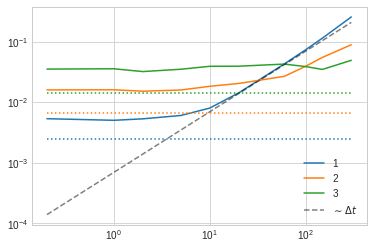

In [44]:
dts = np.array([0.2, 1.0, 2.0, 5.0, 10.0, 20, 60, 100, 150, 300])

for it in [1, 2, 3]:
    mean = np.mean(moments[0,:,0,it])
    l, = plt.plot(dts, np.mean(np.abs(moments[:,:,0,it] - mean), axis = 1), label = it)
    var = np.mean(moments[0,:,1,it])
    Np = np.mean(counts[0,:,it])
    plt.plot(dts, np.sqrt(2/np.pi)*np.sqrt(var/Np)*np.ones_like(dts), ':', c = l.get_color())
#    for i in range(100):
#        plt.scatter(dts, np.abs(moments[:len(dts),i,0,it] - mean))
        

plt.plot(dts, 7e-4*dts, '--', c = 'k', alpha = 0.5, label = '$\sim \Delta t$')

plt.xscale('log')
plt.yscale('log')
plt.legend()

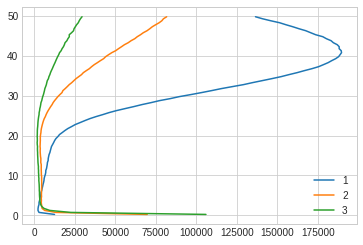

In [25]:
C = np.load('../results/Case2_K_B_lagrangian_Nparticles=10000000_dt=0.2_histogram_Nbins=100_0000.npy')

zf, dz = np.linspace(0, 50, 101, retstep = True)
zc = zf[0:-1] + dz/2

for i in [1,2,3]:
    plt.plot(C[:,i], zc, label = i)
    
plt.legend()

In [35]:
r = np.random.normal(loc = 0, scale = 500, size = 100000)

np.mean(np.abs(r)) / np.std(r)

0.7972474974648764

In [46]:
np.sqrt(2/np.pi)

0.7978845608028654